In [1]:
import os 
os.getcwd()

'/home/sanjana/jupyter/environment'

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *


2022-11-08 15:04:44.805674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 15:04:50.511431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sanjana/jupyter/environment/lib/python3.10/site-packages/cv2/../../lib64:
2022-11-08 15:04:50.511564: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-08 15:04:51.034772: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when on

In [3]:
#setting the image width and height 
image_width = 256
image_height = 256

# loading the image path and masks path 

For each of the MRI image, there will be a corresponding masks image 

In [4]:
image_filenames_train = []

#creating a list of all files containing the word 'mask'

mask_files = glob('/home/sanjana/jupyter/environment/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])

['/home/sanjana/jupyter/environment/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_23.tif', '/home/sanjana/jupyter/environment/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_29.tif', '/home/sanjana/jupyter/environment/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_25.tif', '/home/sanjana/jupyter/environment/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_9.tif', '/home/sanjana/jupyter/environment/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_11.tif', '/home/sanjana/jupyter/environment/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_8.tif', '/home/sanjana/jupyter/environment/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_28.tif', '/home/sanjana/jupyter/environment/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_13.tif', '/home/sanjana/jupyter/environment/lgg-mri-segmen

# lets plot some images and masks 

In [5]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows*columns + 1): #defining a grid 
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
    plt.show()
    

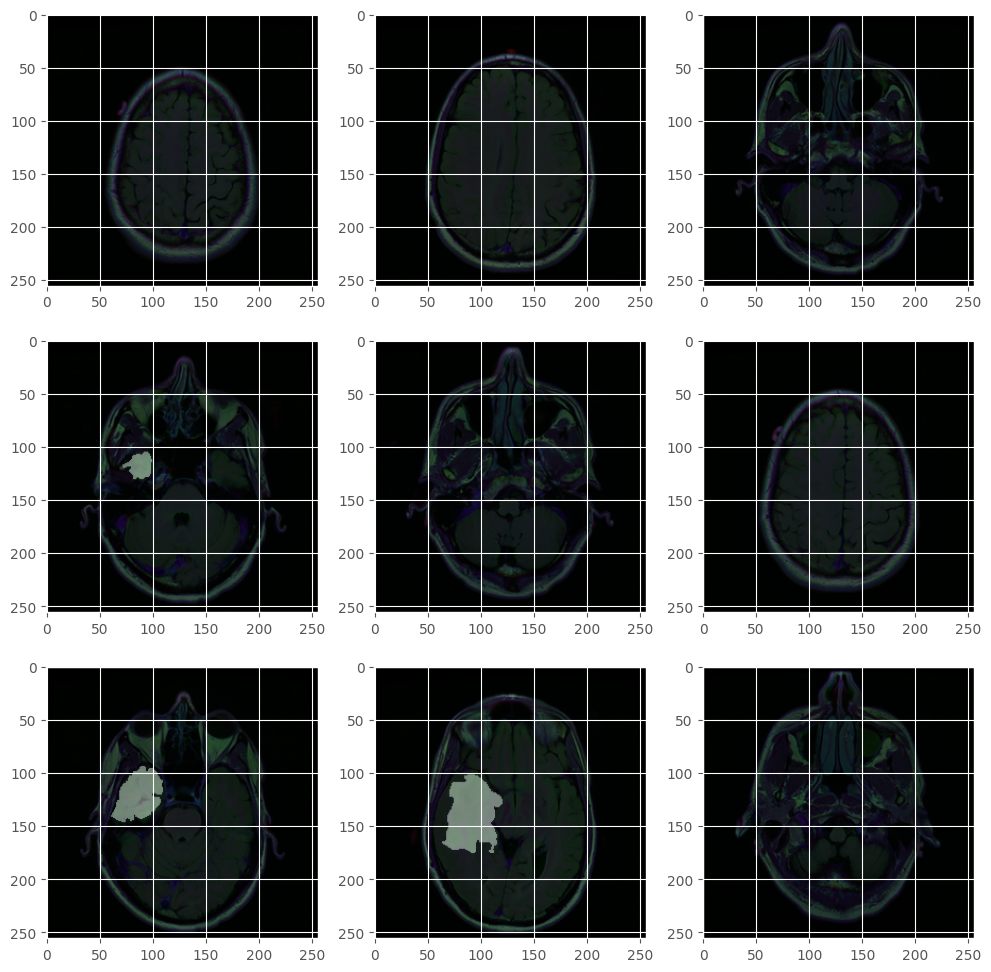

In [6]:
plot_from_img_path(3, 3, image_filenames_train, mask_files) #it randomly prints some images and some masks 

# Split the data on train set, validation set and test set 

In [7]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files})
#print(df.head())
df_train, df_test = train_test_split(df, test_size=0.1)

#Further split this into validation and training

df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


# Data generator, data augmentation and adjust data

Mask of an image is simply an image where some of the pixel intensity values are 0 and some of the pixel intensity values are non-zero. The places where the pixel intensity values are zero can be defined as background and the places where the pixel intensity values are non-zero are usually foreground

In [8]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

After obtaining the mask, the mask needs to be normalized. If the value is <= 0.5 then that mask usually looks completely black in color and it indicates absence of tumor

In [9]:
def normalise_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

# METRICS 

# 1. Dice coefficient

2 * Area of overlap between the two images divided by the total number of pixels in both images 

# 2. Dice coefficient loss

This is calculated as the negative of dice coefficient because when the dice coefficient is high, the accuracy is 
also high. It implies that the loss between the true value and the prediction is low. So dice coefficient is taken 
as the opposite / negative of dice coefficient. 

# 3. Intersection Over Union

# 4. Jaccard Distance

In [10]:
from tensorflow.keras import backend as K

def dice_coefficients(y_true, y_pred, smooth):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    
    intersection = K.sum(y_true_flatten, y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coefficients_loss(y_true, y_pred):
    return -dice_coefficients(y_true, y_pred)

def iou(y_true, y_pred, smooth):
    intersection = K.sum(y_true * y_pred) #multiplication will yield 1 if the prediction and groundtruth is 1 otherwise it will yield 0
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou 

def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)
    

# Unet architecture 

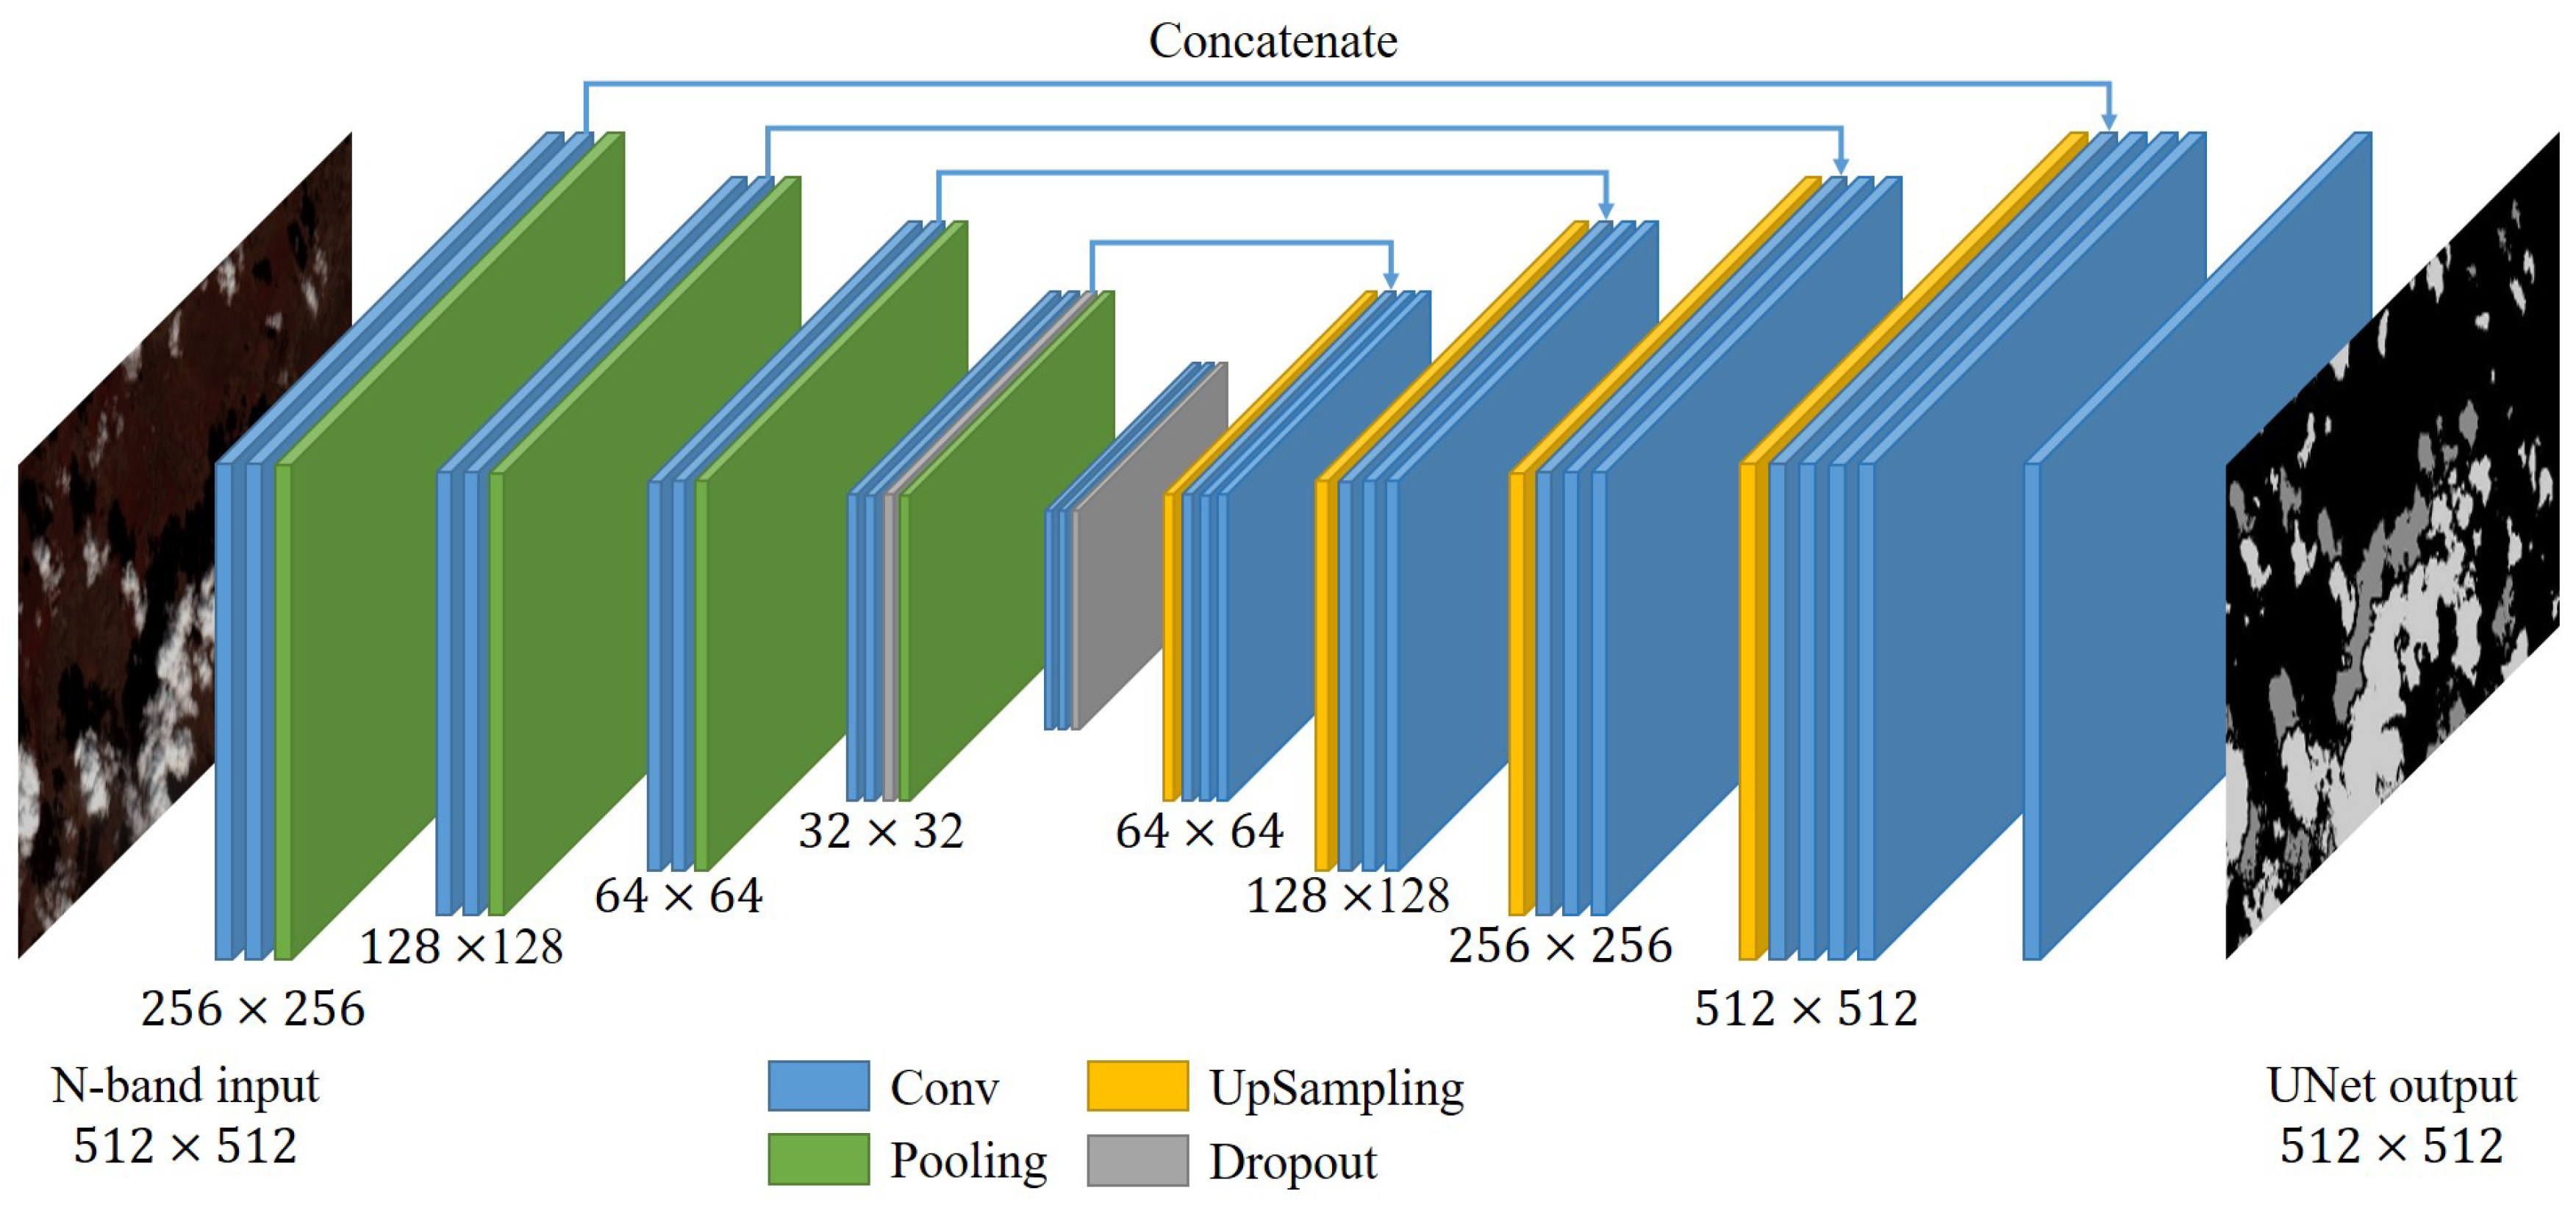

In [14]:
def unet(input_size = (256, 256, 3)):
    input_images_size = Input(input_size)
    
    
    #encoder 
    
    '''Filters usually take sizes such as 64, 128, 256, 512, 1024. While kernels are of sizes (3, 3), (5, 5), (1, 1).
    kernel size refers to the width and height of the filter mask. '''
    
    
    conv1 = Conv2D(filters = 64, kernel = (3, 3), padding = 'same')(input_images_size)
    batchnorm1 = Activation('relu')(conv1)
    conv1 = Conv2D(filters = 64, kernel = (3, 3), padding = 'same')(batchnorm1)
    batchnorm1 = Activation('relu')(conv1)
    batchnorm1 = Activation('relu')(batchnorm1)
    pooling1 = MaxPooling2D(pool_size = (2, 2))(batchnorm1)
    
    
    conv2 = Conv2D(filters = 128, kernel_size = (3, 3), padding='same')(pooling1)
    batchnorm2 = Activation('relu')(conv2)
    conv2 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same')(batchnorm2)
    batchnorm2 = Activation('relu')(conv2)
    batchnorm2 = Activation('relu')(batchnorm2)
    pooling2 = MaxPooling2D(pool_size = (2, 2))(batchnorm2)
    
    
    conv3 = Conv2D(filters = 256, kernel_size = (3, 3), padding='same')(pooling2)
    batchnorm3 = Activation('relu')(conv3)
    conv3 = Conv2D(filters = 256, kernel_size = (3, 3), padding='same')(batchnorm3)
    batchnorm3 = Activation('relu')(conv3)
    batchnorm3 = Activation('relu')(batchnorm3)
    pooling3 = MaxPooling2D(pool_size=(2, 2))(batchnorm3)
    
    conv4 = Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same')(pooling3)
    batchnorm4 = Activation('relu')(conv4)
    conv4 = Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same')(batchnorm4)
    batchnorm4 =  Activation('relu')(conv4)
    batchnorm4 = Activation('relu')(batchnorm4)
    pooling4 = MaxPooling2D(pool_size = (2, 2))(batchnorm4)
    
    conv5 = Conv2D(filters = 1024, kernel_size = (3, 3), padding = 'same')(pooling4)
    batchnorm5 = Activation('relu')(conv5)
    conv5 = Conv2D(filters = 1024, kernel_size = (3, 3), padding = 'same')(batchnorm5)
    batchnorm5 = Activation('relu')(conv5)
    batchnorm5 = Activation('relu')(batchnorm5)
    pooling5 = MaxPooling2D(pool_size = (2, 2))(batchnorm5)
    
    #Decoder
    
    ''' As seen in the image, Unet architecture is a combination of encoder-decoder. 
    Up-conv6 = Up-conv6 + conv4
    Up-conv7 = Up-conv7 + conv3
    Up-conv8 = Up-conv8 + conv2
    Up-conv9 = Up-conv9 + conv1 
    
    Every decoder block is concatenated with an encoder block'''
    
    up_conv6 = concatenate([Conv2DTranspose(512, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(batchnorm5),conv4],
                          axis = 3)
    batchnorm6 = Activation('relu')(up_conv6)
    conv6 = Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same')(batchnorm6)
    batchnorm6 = BatchNormalization(axis = 3)(conv6)
    batchnorm6 = Activation('relu')(batchnorm6)
    
    
    up_conv7 =  concatenate([Conv2DTranspose(256, kernel_size = (2, 2), strides = (2, 2), 
                                            padding = 'same')(batchnorm6), conv3], 
                           axis = 3)
    batchnorm7 = Activation('relu')(up_conv7)
    conv7 = Conv2D(filters = 256, kernel_size = (2, 2), padding = 'same')(batchnorm7)
    batchnorm7 = BatchNormalization(axis = 3)(conv7)
    batchnorm7 = Activation('relu')(batchnorm7)
    
    up_conv8 = concatenate([Conv2DTranspose(128, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(batchnorm6),
                           conv2], 
                          axis = 3)
    batchnorm8 = Activation('relu')(up_conv8)
    conv8 = Conv2D(filters = 128, kernel_size = (2, 2), padding = 'same')(batchnorm8)
    batchnorm8 = BatchNormalization(axis = 3)(conv8)
    batchnorm8 = Activation('relu')(batchnorm8)
    
    up_conv9 =  concatenate([Conv2DTranspose(64, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(batchnorm8),
                            conv1], 
                           axis = 3)
    batchnorm9 = Activation('relu')(up_conv9)
    conv9 = Conv2D(filters = 64, kernel_size = (2, 2), padding = 'same')(batchnorm9)
    batchnorm9 = BatchNormalization(axis = 3)(conv9)
    batchnorm9 = Activation('relu')(batchnorm9)
    
    
    
    #last layer 
    
    conv10 =  Conv2D(filters = 1, kernel_size = (1, 1), padding = 'same')
    
    
    return Model(inputs = [input_images_size], outputs = [conv10])
    
    
    